# Mitigating sampling problems

There are many cases where one is interested in computing the most probable bitstring in the output distribution from a circuit.  Although, M3 returns quasi-probabilities, the most likely bit-string is something that is always positive, and we can mitigate sampling problems of this form.  Below is a simple example for Bernstein–Vazirani (BV) circuits.

## Frontmatter

In [1]:
from qiskit import *
from qiskit_ibm_runtime.fake_provider import FakeKolkata

import mthree

import matplotlib.pyplot as plt
plt.style.use('quantum-light')

In [2]:
backend = FakeKolkata()

## Setup experiment

Here we generate BV circuits for all-ones bit-strings of various lengths, and transpile them against our target backend.  We also create a (not-rigourous) function that finds the most likely bit-string from a distribution.

In [3]:
def bv_ones_circs(N):
    """Create a Bernstein–Vazirani (BV) circuit of width N
    
    Here the bit-string length is N-1
    
    Parameters:
        N (int): Number of qubits in circuit
        
    Returns:
        QuantumCircuit: BV circuit
    """
    qc = QuantumCircuit(N, N-1)
    qc.x(N-1)
    qc.h(range(N))
    qc.cx(range(N-1), N-1)
    qc.h(range(N-1))
    qc.barrier()
    qc.measure(range(N-1), range(N-1))
    return qc


def most_likely_bitstring(dist):
    """Computes the most likely bit-string from a given distribution
    
    Parameters:
        dist (dict): Input distribution
        
    Returns:
        str: Most likely bit-string
        int, float: Most likely value
    """
    sorted_dist = dict(sorted(dist.items(), key=lambda item: item[1], reverse=True))
    key = next(iter(sorted_dist.keys()))
    val = next(iter(sorted_dist.values()))
    return key, val

In [4]:
bit_range = range(2, 13)

circs = [bv_ones_circs(N+1) for N in bit_range]

In [5]:
trans_circs = transpile(circs, backend, optimization_level=3)

## Perform experiment

We generate the raw data for the circuits, and then perform our mitigation in the usual way.

In [6]:
shots = 8192
counts = backend.run(trans_circs, shots=shots).result().get_counts()

Get the success probability, validating that our returned bit-string is what we expect.

In [7]:
raw_success_probs = []

for idx, num_bits in enumerate(bit_range):
    max_bitstring, max_value = most_likely_bitstring(counts[idx])
    if max_bitstring != '1'*num_bits:
        raise Exception('Returned wrong bit-string')
    raw_success_probs.append(max_value/shots)

In [8]:
mit = mthree.M3Mitigation(backend)

In [9]:
mappings = mthree.utils.final_measurement_mapping(trans_circs)

In [10]:
mit.cals_from_system(mappings)

In [11]:
quasis = mit.apply_correction(counts, mappings)

Get the mitigated success probability, validating that our returned bit-string is what we expect.

In [12]:
mit_success_probs = []

for idx, num_bits in enumerate(bit_range):
    max_bitstring, max_value = most_likely_bitstring(quasis[idx])
    if max_bitstring != '1'*num_bits:
        raise Exception('Returned wrong bit-string')
    mit_success_probs.append(max_value)

## Plot results

Here we plot the results

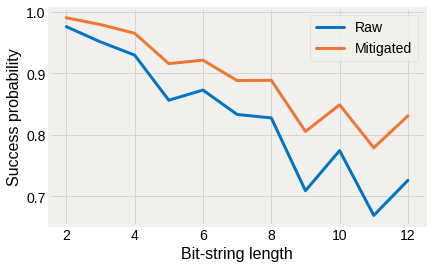

In [13]:
fig, ax = plt.subplots()
ax.plot(bit_range, raw_success_probs, label='Raw')
ax.plot(bit_range, mit_success_probs, label='Mitigated')
ax.set_ylabel('Success probability')
ax.set_xlabel('Bit-string length')
ax.legend();